In [1]:
%load_ext line_profiler

In [2]:
from collections import Counter
from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=180, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

In [3]:
# ns = [0,10,10,11,12,13,14,15,16,17]
# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# ns = [0]


students = np.logspace(-1, 1, 11)
display(students.round(4))

# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 5
# # arrs = np.array([[20,0,0,0,0],
# #                  [19,19,0,0,0],
# #                  [18,18,18,0,0],
# #                  [17,17,17,17,0],
# #                  [16,16,16,16,16],])
# arrs = np.array([[20,0,0,0,0],
#                  [15,16,17,18,19],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  [0,0,0,0,0],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                  # [-1000,-1000,-1000,-1000,-1000],
#                 ])
# arrs = arrs / 20
# display(arrs)
# display(arrs.sum().round(2))


ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
ms = 10
arrs = np.array([[20,0,0,0,0,0,0,0,0,0],
                 [19,18,17,16,15,14,13,12,11,10],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                 [0,0,0,0,0,0,0,0,0,0],
                ])
arrs = arrs / 20
display(arrs)
display(arrs.sum().round(2))
                 
                 

# ms = 4
# arrs = np.triu(np.tile(np.arange(31, 35),(4,1)).T) - 20
# display(arrs)
# display(arrs.sum())


# ns = [0,5,5,6,7,8,9,10,11,12,13,14,15]
# ms = 2
# arrs = np.array([[1,0],[.99,.99]])
# display(arrs)
# display(arrs.sum().round(2))


ranked = False
slip = False

array([ 0.1   ,  0.1585,  0.2512,  0.3981,  0.631 ,  1.    ,  1.5849,  2.5119,  3.9811,  6.3096, 10.    ])

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

8.25

In [4]:
def make_model(num_nodes=128, num_dense=4):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    
    inputs = tf.keras.layers.Input(shape=(ms*ms + ms + 1))
    x = tf.keras.layers.Flatten()(inputs)
    for _ in range(num_dense):
        x = tf.keras.layers.Dense(num_nodes, activation='relu')(x)
    output1 = tf.keras.layers.Dense(ms, name='Y0')(x)
    output1 = tf.keras.layers.Softmax()(output1)
    model = tf.keras.models.Model(inputs=inputs, outputs=output1)
    
    opt = tf.keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1)
    # opt = tf.keras.optimizers.SGD()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    return model

def softmax(x, b, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    return np.exp(x/b) / np.exp(x/b).sum(axis=axis, keepdims=True)

# def softmax(x, b, axis=-1):
#     x = x - np.max(x)
#     with np.errstate(divide='ignore', invalid='ignore'):
#         res = np.exp(x/b) / np.exp(x/b).sum(axis=-1, keepdims=True)
#         res = np.nan_to_num(res)
#     return res

def make_x():
    x = arrs
    
    # rand = np.random.random(arrs.shape)
    # rand = (rand - 0.5)
    # x = x + rand*0.0001
    
    x = rng.permuted(x, axis=-1)
    return x

def eval_model(model, n = 1, disable=True):
    rewards = []
    branch_rewards = []
    for _ in trange(n, disable=disable):
        x = make_x()
        x_tree = np.concatenate([np.eye(ms+1).astype(int), np.tile(x.flatten(), (ms+1,1))], axis=1)
        y_pred = model(x_tree)
        branch_reward = (x_tree[0,ms+1:].reshape(ms,ms) * y_pred[1:].numpy()).sum(axis=1)
        rewards.append(y_pred[0].numpy())
        # reward = (y_pred[0] * branch_reward).numpy().sum()
        # rewards.append(reward)
        branch_rewards.append(branch_reward)
    return np.array(rewards), np.array(branch_rewards)

def make_data(b=1, n=1, disable=True):
    X, Y = [], []
    for _ in trange(n, disable=disable):
        
        if ranked:
            x = make_x()
            r1 = softmax(rankdata(x,axis=1), b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(rankdata(r1sum), b)
                    
        else:
            x = make_x()
            r1 = softmax(x, b)
            r1sum = (r1*x).sum(axis=1)
            r0 = softmax(r1sum, b)
        
        pos = [0] * (ms+1)
        pos[0] = 1
        x0 = pos + list(x.flatten())
        
        
        # slip_prob = np.log10(b)/-20 + 0.95
        slip_prob = np.log10(b) * -0.45 + 0.55
        
        if slip == False:
            y0 = rng.choice(np.arange(ms), p=r0)
        else:
            p = np.zeros(ms) + (1-slip_prob)/(ms-1)
            p[0] = slip_prob
            y0 = rng.choice(np.arange(ms), p=p)
        # while y0 in [2,3,4]:
        #     y0 = rng.choice(np.arange(ms), p=r0)
            
        
        pos = [0] * (ms+1)
        pos[y0+1] = 1
        x1 = pos + list(x.flatten())
        
        if slip == False:
            y1 = rng.choice(np.arange(ms), p=r1[y0])
        else:
            p = np.zeros(ms) + (1-slip_prob)/(ms-1)
            
            p[r1.argmax()] = slip_prob
            y1 = rng.choice(np.arange(ms), p=p)

        X.append(x0)
        Y.append(y0)
        X.append(x1)
        Y.append(y1)
    
    X = np.array(X)
    Y = np.array(Y)
    
    return X,Y

In [5]:
%%time
for b in students:
    r0s = []
    r1s = []
    for _ in trange(10000, disable=True):
        x = make_x()
        
        if ranked:
            r1 = (softmax(rankdata(x,axis=1), b) * x).sum(axis=1)
            r0 = (softmax(rankdata(r1), b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
            
        else:
            r1 = (softmax(x, b) * x).sum(axis=1)
            r0 = (softmax(r1, b) * r1).sum()
            r1s.append(r1)
            r0s.append(r0)
    
        
    r1s = np.array(r1s)
    r0s = np.array(r0s)
    print(f"{b:.3f}, {r0s.mean():.3f}, {r1s.mean(axis=0).round(3)}, {softmax(r1s.mean(axis=0), b).round(3)}")

0.100, 0.971, [1.    0.876 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.774 0.226 0.    0.    0.    0.    0.    0.    0.    0.   ]
0.158, 0.932, [0.984 0.837 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.708 0.281 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
0.251, 0.726, [0.856 0.802 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.483 0.389 0.016 0.016 0.016 0.016 0.016 0.016 0.016 0.016]
0.398, 0.410, [0.578 0.775 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.221 0.364 0.052 0.052 0.052 0.052 0.052 0.052 0.052 0.052]
0.631, 0.239, [0.352 0.757 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.134 0.254 0.077 0.077 0.077 0.077 0.077 0.077 0.077 0.077]
1.000, 0.164, [0.232 0.746 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.111 0.185 0.088 0.088 0.088 0.088 0.088 0.088 0.088 0.088]
1.585, 0.128, [0.173 0.738 0.    0.    0.    0.    0.    0.    0.    0.   ], [0.104 0.149 0.093 0.093 0.093 0.093 0.093 0.093 0.093 0.093]
2.512, 0.109, [0.142 0.733 

In [6]:
def train_model(student):
    verbose = False
    if student == 1:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**16, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/starting_{student:.3f}.keras')
    return reward

In [7]:
%%time
rewards = process_map(train_model, students, disable=True, max_workers=11)

student == 1.000


  0%|          | 0/65536 [00:00<?, ?it/s]

4096/4096 [==============================] - 21s 5ms/step - loss: 2.2864 - accuracy: 0.1436


  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 809 ms, sys: 735 ms, total: 1.54 s
Wall time: 1min 28s


In [8]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

0.100 0.955692839423013
0.158 0.8954595551616581
0.251 0.6988326184705456
0.398 0.38585751483352737
0.631 0.21161337514121142
1.000 0.15369849105588554
1.585 0.11637271789107667
2.512 0.10517467008161782
3.981 0.09119501171017014
6.310 0.08622908792381856
10.000 0.0848209644317711


# Graphs

In [ ]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.get_logger().setLevel('ERROR')
model2 = tf.keras.models.load_model(f"models/starting_{0.100:.3f}.keras")
%timeit r0, r1 = eval_model(model2, 1)

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomCallback, self).__init__()

    def on_batch_end(self, batch, logs=None):
        
        r0, r1 = eval_model(self.model, 10)
        r = (r0*r1).sum(axis=1).mean()
        try:
            self.model.rewards.append(r)
            self.model.accs.append(logs['accuracy'])
        except:
            self.model.rewards = [r]
            self.model.accs = [logs['accuracy']]

In [ ]:
models = {}

In [ ]:
%%time

with open('tree.log', 'a') as f:
    for student in students:
        
        print(f'student {student:.3f}', file=f, flush=True)

        models[student] = {}

        for teacher in students[::2][3:10]:

            print(f'teacher {teacher:.3f}', file=f, flush=True)
            models[student][teacher] = []
            for i in range(5):
                print(f'model {i}', file=f, flush=True)
                # model = make_model()
                model = tf.keras.models.load_model(f"models/starting_{student:.3f}.keras")

                opt = tf.keras.optimizers.Adam()
                loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

                X, Y = currs[f'{teacher:.3f}']
                model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()], verbose=False)
                # model.fit(X[:2**17], Y[:2**17], callbacks=[CustomCallback()])

                models[student][teacher].append(model)


        #         break
        #     break
        # break

In [ ]:
for student, s_models in models.items():
    # print(student, list(s_models))
    df = {}
    for teacher, model in s_models.items():
        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        rewards = np.array([m.rewards for m in model]).mean(axis=0)
        rewards = np.convolve(rewards, kernel, mode='valid')
        df[f"{teacher:.3f}"] = rewards
    df = pd.DataFrame(df)
    
    print(f'Student {student:.3f}')
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.lineplot(df[[c for c in df.columns if float(c) >= student]])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.show()
    print()

In [ ]:
df[[c for c in df.columns if float(c) >= 1]]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    ax = sns.lineplot(df)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
1+1

In [ ]:
ax = sns.lineplot(df[df.columns[4:9]])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
students[::2][4:9]

In [ ]:
2**17 // 32

# Eval Training

In [464]:
def eval_training(student, teachers, verbose=False):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.get_logger().setLevel('ERROR')
        
        
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(CustomCallback, self).__init__()

        def on_batch_end(self, batch, logs=None):
            
            # batches = list(2**np.arange(5,18) // 32 - 1)            
            # if batch in batches:
                
            if batch % 1 == 0:
                r0, r1 = eval_model(self.model, 10)
                r = (r0*r1).sum(axis=1).mean()
                try:
                    self.model.rewards[batch] = r
                    # self.model.accs.append(logs['accuracy'])
                except:
                    self.model.rewards = {batch: r}
                    # self.model.accs = [logs['accuracy']]

    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/starting_{student:.3f}.keras")
        
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    
    bs = 32
    
    if teachers == ('smooth',):
        _X1, _Y1 = currs[f"{0.158:.3f}"]
        _X0, _Y0 = currs[f"{0.1:.3f}"]
        
        perm = np.random.permutation(len(_X1))[:200*bs]
        _X1, _Y1 = _X1[perm], _Y1[perm]
        
        perm = np.random.permutation(len(_X0))[:200*bs]
        _X0, _Y0 = _X0[perm], _Y0[perm]
        
        where = np.concatenate([np.zeros(75*bs) , np.linspace(0,1,50*bs), np.ones(75*bs)])
        where = where > np.random.random(200*bs)
        
        
        X = np.where(where.reshape((-1, 1)), _X0, _X1)
        Y = np.where(where, _Y0, _Y1)
        
    
    else:
        X, Y = [], []
        for teacher, n in teachers:
            _X, _Y = currs[f"{teacher:.3f}"]
            perm = np.random.permutation(len(_X))[:n*bs]
            X.append(_X[perm])
            Y.append(_Y[perm])
        X, Y = np.concatenate(X), np.concatenate(Y)
        
    model2.fit(X, Y, verbose=False, shuffle=False, batch_size=bs, callbacks=[CustomCallback()])    
    return (student, teachers, model2.rewards)


In [472]:
def exp(student, verbose=True, n=20):
    # teachers = np.arange(student, 0.40001, 0.02)
    
    # teachers = students[:6]
    
    teachers = [
                ((0.1, 200),),
                ((0.158, 200),),
                ((0.251, 200),),
                ((0.398, 200),),
                ((0.631, 200),),
                # ((0.158, 25),(0.1, 175),),
                # ((0.158, 50),(0.1, 150),),
                # ((0.158, 75),(0.1, 125),),
                # ((0.158, 100),(0.1, 100),),
                # ((0.158, 125),(0.1, 75),),
                # ((1, 128),),
                # ("smooth",)
               ]
    
    # teachers = [((0.1, 128),),
    #             ((0.251, 128),),
    #             ((0.251, 20),(0.1, 108),),
    #             ((0.158, 20),(0.1, 108),),
    #             ((0.251, 20),(0.158, 20),(0.1, 88),),]
        
    t_ = list(teachers) * n
    s_ = [student for _ in t_]
    
    res = process_map(eval_training, s_, t_, max_workers=21, chunksize=1)
    
    return res

In [473]:
%%time
res = exp(10, n=10)#.reshape(-1, len(students), len(ns)).mean(axis=0).round(2)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

Process ForkProcess-841:
Process ForkProcess-835:
Process ForkProcess-840:
Process ForkProcess-831:
Process ForkProcess-839:
Process ForkProcess-822:
Process ForkProcess-836:
Process ForkProcess-833:
Process ForkProcess-829:
Traceback (most recent call last):
Process ForkProcess-821:
Traceback (most recent call last):
Process ForkProcess-832:
Process ForkProcess-828:
Process ForkProcess-824:
Traceback (most recent call last):
Process ForkProcess-837:
Process ForkProcess-827:
Traceback (most recent call last):
Process ForkProcess-823:
Process ForkProcess-834:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/li

In [467]:
res2 = {}
for s, t, d in res:
    s = f"{s:.3f}"

    if (s,t) not in res2:
        res2[s,t] = [list(d.values())]
    else:
        res2[s,t].append(list(d.values()))

res2 = {k:list(np.array(v)) for k,v in res2.items()}

In [468]:
df = pd.DataFrame(res2.values())
df.index = res2.keys()
df.index.names = ('Student', 'Teacher')
df = df.melt(ignore_index=False, var_name='Exp', value_name='Perf')
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
    df[(np.array(list(res[0][2])) + 1)] = df.Perf.tolist()
df = df.drop(columns='Perf')
df = df.reset_index().set_index(['Student','Teacher','Exp'])
df = df.melt(ignore_index=False, var_name='Batch', value_name='Perf').reset_index()
df

,Student,Teacher,Exp,Batch,Perf
0,10.000,"((0.1, 200),)",0,1,0.084939
1,10.000,"((0.158, 200),)",0,1,0.084960
2,10.000,"((0.158, 100), (0.1, 100))",0,1,0.084960
3,10.000,"(smooth,)",0,1,0.084960
4,10.000,"((0.1, 200),)",1,1,0.084939
...,...,...,...,...,...
79995,10.000,"(smooth,)",98,200,0.516257
79996,10.000,"((0.1, 200),)",99,200,0.605826
79997,10.000,"((0.158, 200),)",99,200,0.570019
79998,10.000,"((0.158, 100), (0.1, 100))",99,200,0.630308


In [469]:
df2 = df.groupby(['Teacher','Batch']).Perf.mean().reset_index()
df2['Perf2'] = df2.groupby('Teacher')['Perf'].transform(lambda x: x.rolling(10,1).mean())
df2

,Teacher,Batch,Perf,Perf2
0,"((0.1, 200),)",1,0.084951,0.084951
1,"((0.1, 200),)",2,0.085121,0.085036
2,"((0.1, 200),)",3,0.085256,0.085109
3,"((0.1, 200),)",4,0.085439,0.085192
4,"((0.1, 200),)",5,0.085632,0.085280
...,...,...,...,...
795,"(smooth,)",196,0.576250,0.550955
796,"(smooth,)",197,0.561373,0.553943
797,"(smooth,)",198,0.573193,0.558654
798,"(smooth,)",199,0.579239,0.561915


In [470]:
sub = [
    ((0.1, 200),),
    ((0.158, 200),),
    # ((0.158, 25),(0.1, 175),),
    # ((0.158, 50),(0.1, 150),),
    # ((0.158, 75),(0.1, 125),),
    # ((0.158, 100),(0.1, 100),),
    # ((0.158, 125),(0.1, 75),),
    ("smooth",),
]

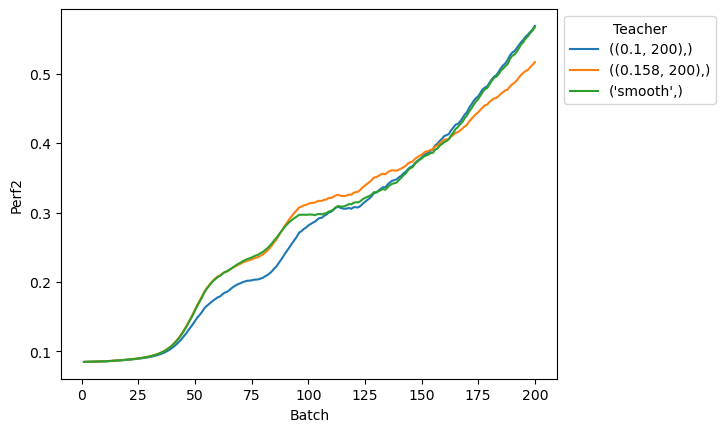

In [471]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[df2.Teacher.isin(sub)], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    # ax = sns.lineplot(df2[df2.Teacher=='scale'], x='Batch', y='Perf2', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [12]:
%%time
ntotal = (2**np.array(ns[1:11])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=11, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 146 ms, sys: 280 ms, total: 426 ms
Wall time: 3.23 s
